In [14]:
# face detection for the 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
import pickle
 
# extract a single face from a given photograph
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces
 
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)


# load train dataset
trainX, trainy = load_dataset('stream/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('stream/val/')
# save arrays to one file in compressed format
savez_compressed('personal.npz', trainX, trainy, testX, testy)

>loaded 5 examples for class: Jose_Luis
>loaded 5 examples for class: Patricia
(10, 160, 160, 3) (10,)
>loaded 3 examples for class: Jose_Luis
>loaded 3 examples for class: Patricia


In [15]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model
 
# get the face embedding for one face
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]
 
# load the face dataset
data = load('personal.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

# load the facenet model
model = load_model('facenet_keras.h5')
print('Loaded Model')

# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)

# save arrays to one file in compressed format
savez_compressed('personal-embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (10, 160, 160, 3) (10,) (6, 160, 160, 3) (6,)


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Loaded Model
(10, 128)
(6, 128)


In [17]:
# develop a classifier for the new photo
from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
import joblib
import numpy as np

# load faces
data = load('personal.npz')
testX_faces = data['arr_2']

# load face embeddings
data = load('personal-embeddings.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']

# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

# fit model
model_svc = SVC(kernel='linear', probability=True, random_state=0)
model_svc.fit(trainX, trainy)

# save the model to disk
filename = 'svc3.sav'
joblib.dump(model, filename)

['svc3.sav']

Predicted: Jose_Luis (79.125)
Expected: Jose_Luis


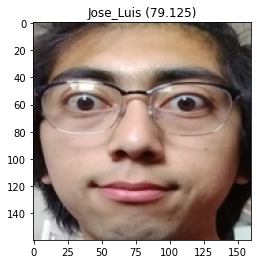

Predicted: Jose_Luis (88.427)
Expected: Jose_Luis


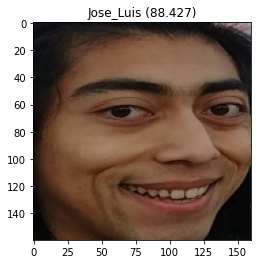

Predicted: Jose_Luis (87.452)
Expected: Jose_Luis


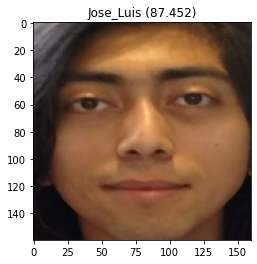

Predicted: Patricia (88.364)
Expected: Patricia


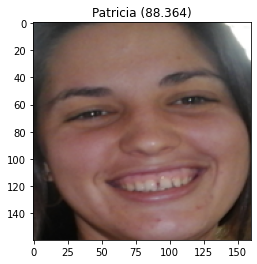

Predicted: Patricia (89.425)
Expected: Patricia


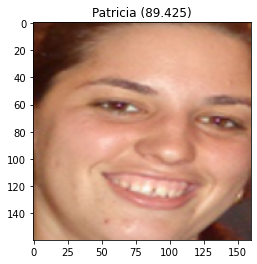

Predicted: Patricia (87.973)
Expected: Patricia


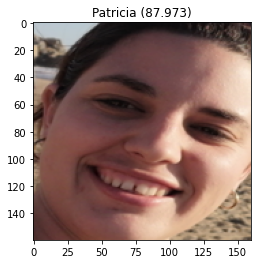

In [18]:
#Define True Positive (TP) and False Positive (FP)
TP = []
FP = []

#Store predicted classes and probabilities
prediction = []
probabilities = []
classes = []

# Predict every face in the test set and compare with the expected label
for i in range(len(testX_faces)):
    face_pixels = testX_faces[i]
    face_emb = testX[i]
    face_class = testy[i]
    face_name = out_encoder.inverse_transform([testy[i]])
    
    # prediction for the face
    #sample = expand_dims(testX[i], axis=0)
    sample = face_emb.reshape(1, 128)
    yhat_class = model.predict(sample)
    prediction.append(yhat_class)
    yhat_prob = model.predict_proba(sample)
    probabilities.append(yhat_prob)
    
    #Compare with expected label
    if yhat_class == face_class:
        TP.append(i)
    else:
        FP.append(i)
        
     # get name
    all_class_index = yhat_class[0]
    all_class_probability = yhat_prob[0,all_class_index] * 100
    predict_all_names = out_encoder.inverse_transform(yhat_class)
    classes.append(predict_all_names)
    print('Predicted: %s (%.3f)' % (predict_all_names[0], all_class_probability))
    print('Expected: %s' % face_name[0])

    # plot for fun
    pyplot.imshow(face_pixels)
    title_2 = '%s (%.3f)' % (predict_all_names[0], all_class_probability)
    pyplot.title(title_2)
    pyplot.show()

System accuracy
Correctly classify: 100.0%
Incorrectly classify: 0.0%


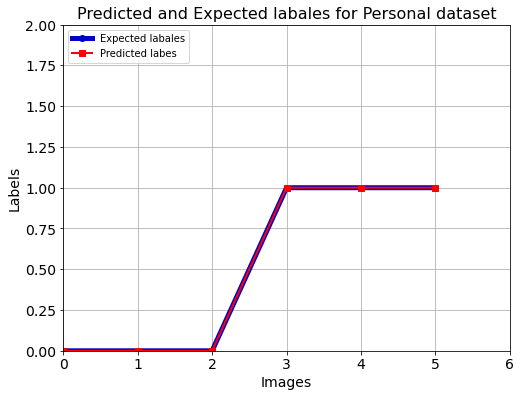

In [25]:
import matplotlib.pyplot as plt

#Metrics
TP_perc = (len(TP)/len(testX_faces))*100
FP_perc = (len(FP)/len(testX_faces))*100
X = float(TP_perc)
Y = float(FP_perc)
TPR  = round(X, 2)
FPR  = round(Y, 2)

print('System accuracy')
print('Correctly classify: %s' % (TPR) + '%')
print('Incorrectly classify: %s' % (FPR) + '%') 

#Plotting labels
f, ax1 = plt.subplots(1, 1, sharex=True, figsize=(8, 6))

ax1.plot(testy, color="mediumblue", linestyle="-", marker="o", linewidth=5, label="Expected labales")
ax1.plot(prediction, color="r", linestyle="-", marker="s", linewidth=2, label="Predicted labes")

ax1.set_title('Predicted and Expected labales for Personal dataset', fontsize=16, fontweight='normal')
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
plt.legend(loc='upper left')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('Images', fontsize=14)
plt.ylabel('Labels', fontsize=14)
plt.xlim(0, 6)
plt.ylim(0, 2)
plt.grid(b=None, which='major', axis='both')
plt.savefig('predicted vs. expected-personal.png')
plt.show()

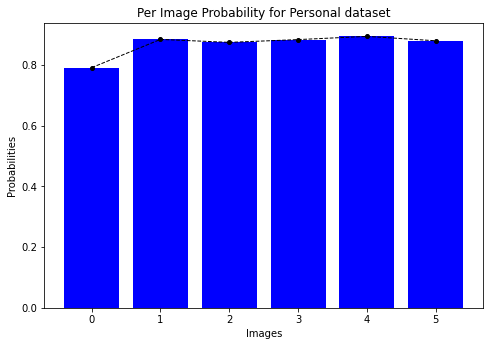

In [26]:
prob = []
for i in probabilities:
    prob.append(max(max(i)))

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

labels = []
for i in range(len(prob)):
    if testy[i] != testy[i-1]:
        labels.append(classes[i])
        
ax.set_xlabel("Images")
ax.set_ylabel('Probabilities')
ax.set_title("Per Image Probability for Personal dataset")

colors = np.random.rand(len(labels),3)

for i in range(len(prob)):
    ax.bar(i, prob[i], color='b')
#plt.xticks(range(len(prob)), range(len(prob)), fontsize=5, rotation=0)
ax.plot(range(len(prob)), prob[0:], color='black', marker='o', linestyle='dashed', linewidth = 1, markersize = 4)
fig.tight_layout(pad=5) 

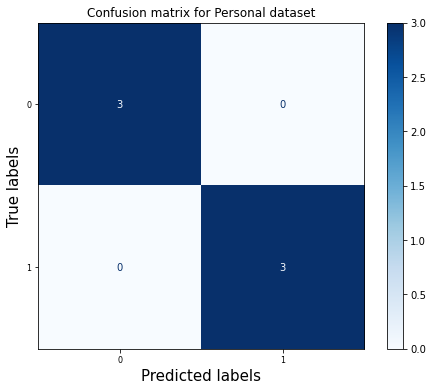

In [29]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
C = plot_confusion_matrix(model, testX, testy, xticks_rotation = 0, cmap=plt.cm.Blues, ax = ax)
                  
C.ax_.set_title("Confusion matrix for Personal dataset")
ax.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Predicted labels', fontsize = 15)
plt.ylabel('True labels', fontsize = 15)
    #print(title)
   # print(C.confusion_matrix)

plt.show()